In [2]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV, LeaveOneGroupOut
from sklearn.pipeline import Pipeline
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import cm
from matplotlib.colors import Normalize

# Pain prediction (low-moderate)

In [3]:
features_df = pd.read_pickle("data/df_for_predictions.pkl")
exercise_type = "back extension set"
filtered_df = features_df[features_df['Exercise'] == exercise_type]
filtered_df = filtered_df.drop(columns=["Exercise"])
filtered_df['Roland-Morris_binary'] = (filtered_df['Roland-Morris'] >= filtered_df['Roland-Morris'].median()).astype(int)
filtered_df['Oswestry_Index_binary'] = (filtered_df['Oswestry Index'] >= filtered_df['Oswestry Index'].median()).astype(int)
print(filtered_df.shape)

(532, 773)


Filter out where a participant didn't have at least 5 repetitons

In [4]:
# Filter out repetitions with less than 3 occurrences per participant and session_id
filtered_reps = filtered_df.groupby(['Participant', 'session_id']).filter(lambda x: len(x) >= 3)
pain_features = ['Roland-Morris', 'Oswestry Index', 'Roland-Morris_binary', 'Oswestry_Index_binary']
feature_names = [col for col in filtered_reps.columns if col not in pain_features + ['Participant', 'session_id', 'Rep']]
X_class = filtered_reps[feature_names].values
y = filtered_reps['Oswestry_Index_binary'].values
participants = filtered_reps['Participant']
filtered_reps.shape

(532, 773)

In [5]:
# Print the counts of 0s and 1s for Oswestry Index and Roland-Morris binary columns
oi_counts = filtered_reps['Oswestry_Index_binary'].value_counts()
rm_counts = filtered_reps['Roland-Morris_binary'].value_counts()

print("Oswestry Index Binary Counts:")
print(f"  Number of 0s: {oi_counts.get(0, 0)}")
print(f"  Number of 1s: {oi_counts.get(1, 0)}")

print("\nRoland-Morris Binary Counts:")
print(f"  Number of 0s: {rm_counts.get(0, 0)}")
print(f"  Number of 1s: {rm_counts.get(1, 0)}")


Oswestry Index Binary Counts:
  Number of 0s: 263
  Number of 1s: 269

Roland-Morris Binary Counts:
  Number of 0s: 260
  Number of 1s: 272


Create counts of low (0) and high (1) levels per participant for Oswestry Index binary column

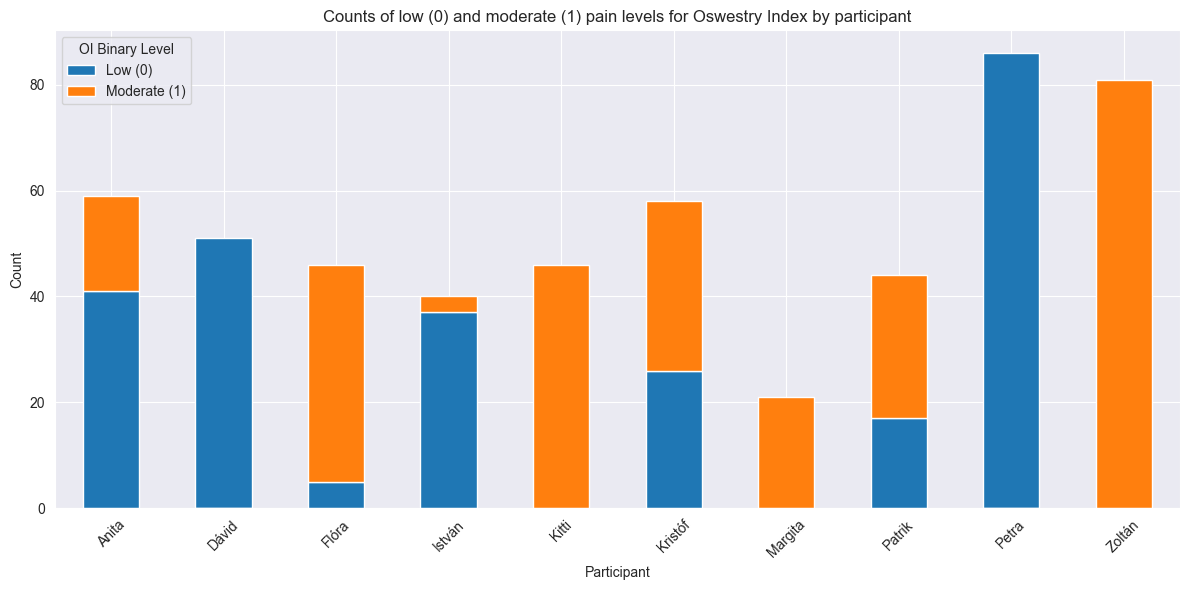

In [6]:

participant_oi_counts = filtered_reps.groupby('Participant')['Oswestry_Index_binary'].value_counts().unstack(fill_value=0)

# Plotting the counts
participant_oi_counts.plot(kind='bar', stacked=True, figsize=(12, 6))

# Add labels and title
plt.xlabel("Participant")
plt.ylabel("Count")
plt.title("Counts of low (0) and moderate (1) pain levels for Oswestry Index by participant")
plt.legend(title="OI Binary Level", labels=["Low (0)", "Moderate (1)"])
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

Prediction: different models - all features/PCA features/RFE features

In [7]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced"),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(kernel="rbf", C=0.1, gamma="scale", random_state=42, class_weight="balanced"),
}

logo = LeaveOneGroupOut()
results = {}
selected_features_by_model = {}

for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")

    # --- Initial Evaluation with All Features ---
    pipeline_all_features = Pipeline([
        ("scaler", StandardScaler()),  # Scale data
        ("classifier", model),        # Classifier model
    ])
    initial_scores = cross_val_score(
        pipeline_all_features, X_class, y,
        cv=logo.split(X_class, y, groups=participants),
        scoring="accuracy", n_jobs=-1
    )
    initial_mean = initial_scores.mean()
    initial_std = initial_scores.std()
    print(f"Initial Accuracy (All Features): {initial_mean:.4f} ± {initial_std:.4f}")

    # --- PCA Reduction ---
    # Fit PCA to the data
    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_class)

    # Number of components selected
    num_features_pca = pca.n_components_
    print(f"Number of features selected by PCA: {num_features_pca}")
    pipeline_pca = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", pca),
        ("classifier", model),
    ])
    pca_scores = cross_val_score(
        pipeline_pca, X_class, y,
        cv=logo.split(X_class, y, groups=participants),
        scoring="accuracy", n_jobs=-1
    )
    pca_mean = pca_scores.mean()
    pca_std = pca_scores.std()
    print(f"Accuracy after PCA: {pca_mean:.4f} ± {pca_std:.4f}")

    # --- RFECV Reduction (if supported) ---
    if model_name in ["Logistic Regression", "Random Forest"]:
        rfecv = RFECV(estimator=model, step=5, cv=logo, scoring="accuracy", n_jobs=-1)
        rfecv.fit(X_class, y, groups=participants)
        selected_features_mask = rfecv.support_
        selected_features = np.array(feature_names)[selected_features_mask]
        
        # Store selected features
        selected_features_by_model[model_name] = selected_features
        X_selected_rfe = X_class[:, selected_features_mask]

        pipeline_rfe = Pipeline([
            ("scaler", StandardScaler()),
            ("classifier", model),
        ])
        rfe_scores = cross_val_score(
            pipeline_rfe, X_selected_rfe, y,
            cv=logo.split(X_selected_rfe, y, groups=participants),
            scoring="accuracy", n_jobs=-1
        )
        rfe_mean = rfe_scores.mean()
        rfe_std = rfe_scores.std()
        print(f"Accuracy after RFE: {rfe_mean:.4f} ± {rfe_std:.4f}")
        print(f"Selected Features by RFE for {model_name}: {selected_features}")
        num_features_rfe = X_selected_rfe.shape[1]
    else:
        rfe_mean = None
        rfe_std = None
        num_features_rfe = None
        print(f"Skipping RFE for {model_name} (not supported).")

    # Store results for this model
    results[model_name] = {
        "Initial Accuracy": {"Mean": initial_mean, "Std": initial_std},
        "PCA Accuracy": {"Mean": pca_mean, "Std": pca_std},
        "RFE Accuracy": {"Mean": rfe_mean, "Std": rfe_std},
        "Num Features PCA": pca.n_components_,
        "Num Features RFE": num_features_rfe,
    }

# --- Display Results ---
print("\nSummary of Results:")
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    print(f"  Initial Accuracy: {metrics['Initial Accuracy']['Mean']:.4f} ± {metrics['Initial Accuracy']['Std']:.4f}")
    print(f"  PCA Accuracy: {metrics['PCA Accuracy']['Mean']:.4f} ± {metrics['PCA Accuracy']['Std']:.4f}")
    if metrics["RFE Accuracy"]["Mean"] is not None:
        print(f"  RFE Accuracy: {metrics['RFE Accuracy']['Mean']:.4f} ± {metrics['RFE Accuracy']['Std']:.4f}")
        print(f"  Selected Features by RFE: {', '.join(selected_features_by_model[model_name])}")
    else:
        print(f"  RFE Accuracy: Skipped")
    print(f"  Number of Features (PCA): {metrics['Num Features PCA']}")
    print(f"  Number of Features (RFE): {metrics['Num Features RFE'] if metrics['Num Features RFE'] is not None else 'N/A'}")


Evaluating Logistic Regression...
Initial Accuracy (All Features): 0.4403 ± 0.3074
Number of features selected by PCA: 4
Accuracy after PCA: 0.4489 ± 0.3000


C:\Users\Hp\PycharmProjects\thesis-project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Hp\PycharmProjects\thesis-project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Accuracy after RFE: 0.6467 ± 0.2050
Selected Features by RFE for Logistic Regression: ['Right Shoulder y ang_vel_spectral_entropy']

Evaluating Random Forest...
Initial Accuracy (All Features): 0.3876 ± 0.2933
Number of features selected by PCA: 4
Accuracy after PCA: 0.3586 ± 0.1984
Accuracy after RFE: 0.7450 ± 0.1206
Selected Features by RFE for Random Forest: ['right bandpassed_Spectral_Bandwidth' 'Pelvis y acc_mean' 'L5 y acc_mean'
 'Pelvis x vel_std' 'T8 z vel_range' 'Right Shoulder y ang_vel_energy'
 'Right Shoulder y ang_vel_spectral_entropy' 'L5 vel magnitude_mean'
 'T8 vel magnitude_energy' 'Pelvis vel magnitude_mean'
 'L3 ang_vel magnitude_energy']

Evaluating Naive Bayes...
Initial Accuracy (All Features): 0.4918 ± 0.2393
Number of features selected by PCA: 4
Accuracy after PCA: 0.5913 ± 0.2460
Skipping RFE for Naive Bayes (not supported).

Evaluating SVM...
Initial Accuracy (All Features): 0.4492 ± 0.2655
Number of features selected by PCA: 4
Accuracy after PCA: 0.4473 ± 0.2

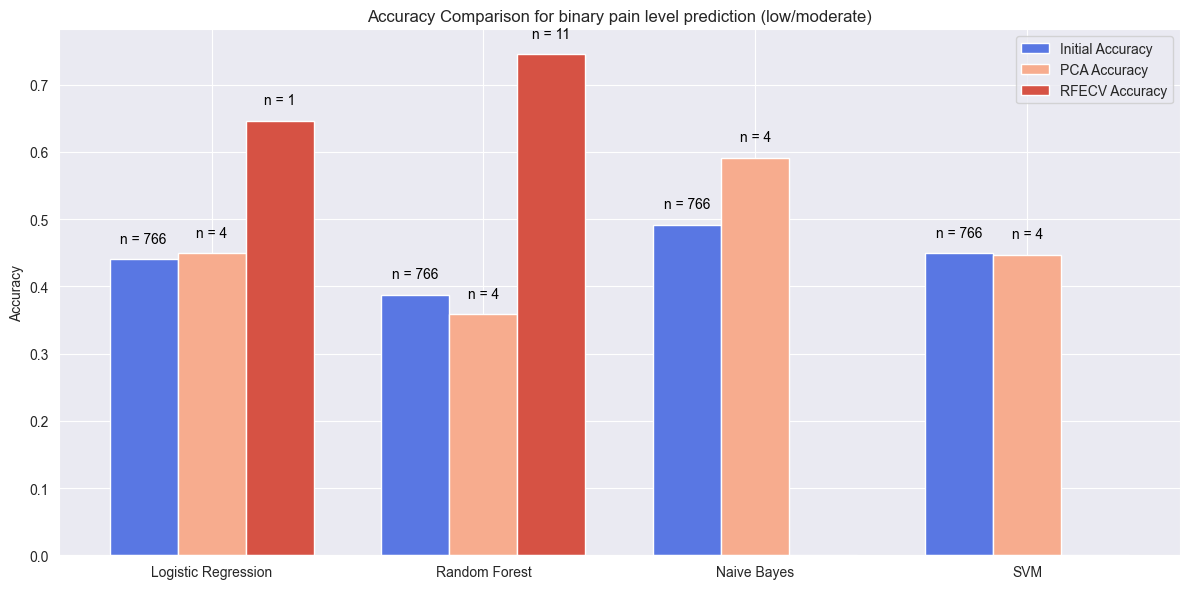

In [8]:
models = list(results.keys())
initial_accuracies = [results[model]["Initial Accuracy"]["Mean"] for model in models]
pca_accuracies = [results[model]["PCA Accuracy"]["Mean"] for model in models]
rfe_accuracies = [
    results[model]["RFE Accuracy"]["Mean"] if results[model]["RFE Accuracy"]["Mean"] is not None else 0
    for model in models
]
num_features_pca = [results[model]["Num Features PCA"] for model in models]
num_features_rfe = [
    results[model]["Num Features RFE"] if results[model]["Num Features RFE"] is not None else 0
    for model in models
]

# Bar Plot for Accuracies
x = np.arange(len(models))
width = 0.25
palette = plt.get_cmap('coolwarm')
colors_initial = palette(0.1)
colors_pca = palette(0.7)
colors_rfe = palette(0.9)

plt.figure(figsize=(12, 6))
initial_bars = plt.bar(x - width, initial_accuracies, width, label='Initial Accuracy', color=colors_initial)
pca_bars = plt.bar(x, pca_accuracies, width, label='PCA Accuracy', color=colors_pca)
rfe_bars = plt.bar(x + width, rfe_accuracies, width, label='RFECV Accuracy', color=colors_rfe)

# Adding annotations for the number of features (Initial, PCA, and RFE)
for i, bar in enumerate(initial_bars):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.02,
        'n = 766',
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

# Adding annotations for the number of features (PCA and RFE)
for i, bar in enumerate(pca_bars):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.02,
        f'n = {num_features_pca[i]}',
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

for i, bar in enumerate(rfe_bars):
    if num_features_rfe[i] > 0:  # Only annotate if features were selected
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.02,
            f'n = {num_features_rfe[i]}',
            ha='center',
            va='bottom',
            fontsize=10,
            color='black'
        )
plt.xticks(x, models)
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison for binary pain level prediction (low/moderate)')
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
selected_features = ['right bandpassed_Spectral_Bandwidth', 'Pelvis y acc_mean', 'L5 y acc_mean', 'Pelvis x vel_std', 'T8 z vel_range', 'Right Shoulder y ang_vel_energy', 'Right Shoulder y ang_vel_spectral_entropy', 'L5 vel magnitude_mean', 'T8 vel magnitude_energy', 'Pelvis vel magnitude_mean', 'L3 ang_vel magnitude_energy']

X_selected = filtered_df[selected_features].values
y = filtered_df['Oswestry_Index_binary'].values
groups = filtered_df['Participant'].values

# Define Random Forest and hyperparameter grid
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [ 2, 4, 6]
}

# Create a pipeline with scaling and the classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', rf)
])

# Define Leave-One-Group-Out CV
logo = LeaveOneGroupOut()

# Perform Grid Search with LOGO-CV
grid_search = GridSearchCV(
    pipeline, param_grid, cv=logo.split(X_selected, y, groups=groups),
    scoring='accuracy', n_jobs=-1, verbose=2
)

# Fit Grid Search
grid_search.fit(X_selected, y)

# Output the best parameters and corresponding score
print("Best Hyperparameters:")
print(grid_search.best_params_)
print(f"Best Accuracy: {grid_search.best_score_:.4f}")


Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Best Hyperparameters:
{'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best Accuracy: 0.7778


C:\Users\Hp\AppData\Local\Temp\ipykernel_20184\3882885482.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Hp\AppData\Local\Temp\ipykernel_20184\3882885482.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Hp\AppData\Local\Temp\ipykernel_20184\3882885482.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Hp\AppData\Local\Temp\ipykernel_20184\3882885482.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set 

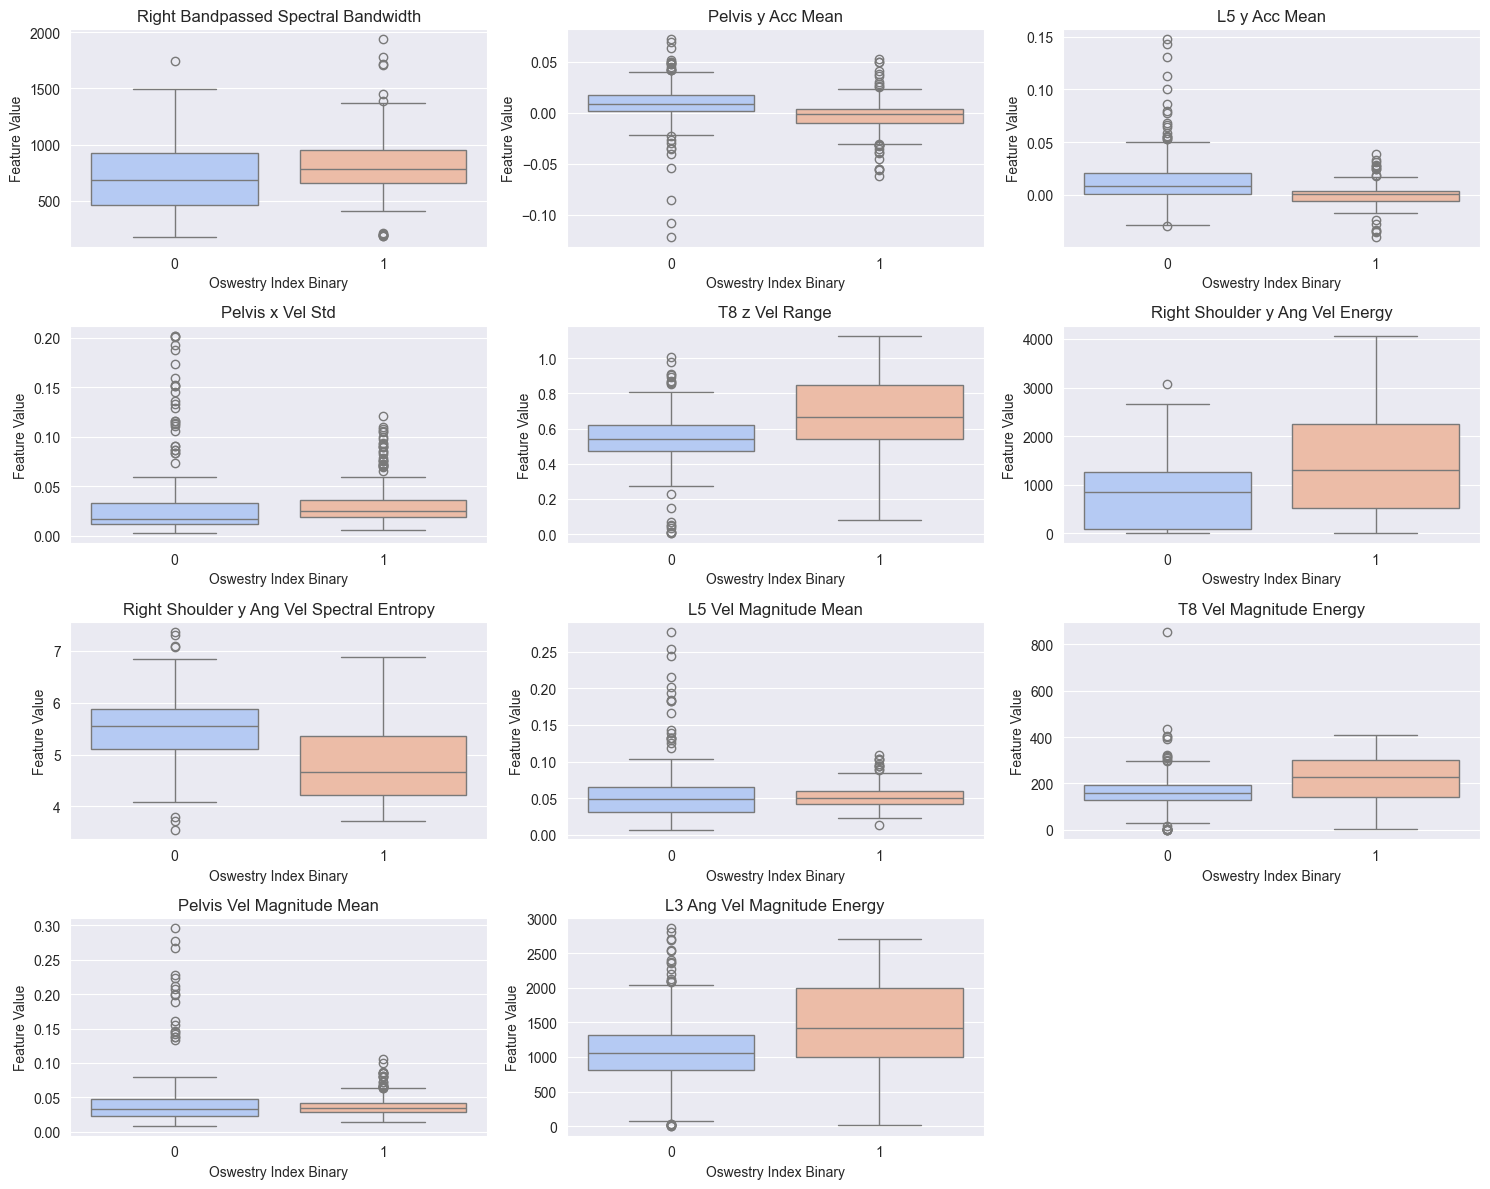

In [51]:
# Define the selected features and their labels
selected_features = [
    'right bandpassed_Spectral_Bandwidth',
    'Pelvis y acc_mean',
    'L5 y acc_mean',
    'Pelvis x vel_std',
    'T8 z vel_range',
    'Right Shoulder y ang_vel_energy',
    'Right Shoulder y ang_vel_spectral_entropy',
    'L5 vel magnitude_mean',
    'T8 vel magnitude_energy',
    'Pelvis vel magnitude_mean',
    'L3 ang_vel magnitude_energy',
]
feature_labels = [
    'Right Bandpassed Spectral Bandwidth',
    'Pelvis y Acc Mean',
    'L5 y Acc Mean',
    'Pelvis x Vel Std',
    'T8 z Vel Range',
    'Right Shoulder y Ang Vel Energy',
    'Right Shoulder y Ang Vel Spectral Entropy',
    'L5 Vel Magnitude Mean',
    'T8 Vel Magnitude Energy',
    'Pelvis Vel Magnitude Mean',
    'L3 Ang Vel Magnitude Energy',
]


plt.figure(figsize=(15, 12))
for i, (feature, label) in enumerate(zip(selected_features, feature_labels), 1):
    plt.subplot(4, 3, i)  # Create a grid of 3x2 subplots
    sns.boxplot(
        x='Oswestry_Index_binary', 
        y=feature, 
        data=filtered_reps, 
        palette='coolwarm'
    )
    plt.title(label)
    plt.xlabel('Oswestry Index Binary')
    plt.ylabel('Feature Value')
plt.tight_layout()
plt.show()

# Week prediction

In [28]:
features_df = pd.read_pickle("data/f.pkl")
exercise_type = "back extension set"
filtered_df = features_df[features_df['Exercise'] == exercise_type]
df = filtered_df.copy()

In [30]:
print(df.shape)
df = df[df['Participant'] != 'Margita'] # nincs első utolsó adata
df = df[df['Participant'] != 'István'] # neki nincs elég felvétel az első hétről, ami back extension-t tartalmaz
df = df[~((df['Participant'] == 'Petra') & (df['session_id'] == 5))]
df = df.reset_index(drop=True)
print(df.shape)

(532, 772)
(461, 772)


In [31]:
df_copy = df.copy()
for participant in df_copy["Participant"].unique():
    unique_sessions = sorted(df_copy[df_copy["Participant"] == participant]["session_id"].unique())
    session_mapping = {original: new for new, original in enumerate(unique_sessions, start=1)}
    df_copy.loc[df_copy["Participant"] == participant, "session_id"] = df_copy.loc[df_copy["Participant"] == participant, "session_id"].map(session_mapping)

print("Updated session IDs for each participant:")
for participant in df_copy["Participant"].unique():
    print(f"Participant: {participant}")
    print("Session IDs:", df_copy[df_copy["Participant"] == participant]["session_id"].unique())
    print()

Updated session IDs for each participant:
Participant: Anita
Session IDs: [1 2 3 4]

Participant: Dávid
Session IDs: [1 2 3 4]

Participant: Flóra
Session IDs: [1 2 3 4]

Participant: Kitti
Session IDs: [1 2 3 4]

Participant: Kristóf
Session IDs: [1 2 3 4]

Participant: Patrik
Session IDs: [1 2 3 4]

Participant: Petra
Session IDs: [1 2 3 4]

Participant: Zoltán
Session IDs: [1 2 3 4]



In [32]:
filtered_df = df_copy
print(filtered_df["Participant"].unique().tolist())
print(filtered_df.shape)

['Anita', 'Dávid', 'Flóra', 'Kitti', 'Kristóf', 'Patrik', 'Petra', 'Zoltán']
(461, 772)


## Random Forest

In [33]:
f = filtered_df[filtered_df["session_id"].isin([1, 4])]
X = f.drop(columns=['Participant', 'session_id', 'Rep', 'Exercise', 'Roland-Morris', 'Oswestry Index'])
y = f['session_id']
groups = f['Participant']

rf_model = RandomForestClassifier(random_state=42, n_estimators=50, min_samples_leaf=2, max_features='sqrt')

feature_names = X.columns
all_feature_importances_logo = []

print("\nRunning Leave-One-Group-Out Cross-Validation...")
cv_scores_logo = []
logo = LeaveOneGroupOut()
for train_idx, test_idx in logo.split(X, y, groups):
    # Scale features within the fold
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X.iloc[train_idx])
    X_test = scaler.transform(X.iloc[test_idx])
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train and evaluate the model
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    cv_scores_logo.append(accuracy_score(y_test, y_pred))
    all_feature_importances_logo.append(rf_model.feature_importances_)

# Average feature importance across folds
mean_importances_logo = np.mean(all_feature_importances_logo, axis=0)
print("LOGO CV Accuracy Scores:", cv_scores_logo)
print("Mean CV Accuracy (LOGO):", np.mean(cv_scores_logo))

importance_logo_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': mean_importances_logo
}).sort_values(by='Importance', ascending=False)

print(importance_logo_df["Feature"].head(20))


Running Leave-One-Group-Out Cross-Validation...
LOGO CV Accuracy Scores: [0.6666666666666666, 0.5945945945945946, 0.8, 1.0, 0.4642857142857143, 0.4166666666666667, 0.7441860465116279, 0.39285714285714285]
Mean CV Accuracy (LOGO): 0.6349071039478016
34     right bandpassed_Fast_Twitch_Slope
14                      right envelope_WL
15                     right envelope_MFL
195                 Pelvis x vel_skewness
110                     L3 y acc_variance
32          right bandpassed_Twitch_Ratio
35     right bandpassed_Slow_Twitch_Slope
12                     right envelope_SSI
13                     right envelope_VAR
495                   T12 x ang_acc_range
254                     L3 x vel_variance
277                         T12 x vel_std
276                        T12 x vel_mean
41                      Pelvis x acc_mean
311              Right Shoulder x vel_std
488                     L3 y ang_acc_mean
17                     right envelope_Max
280           T12 x vel_abs_max_fft_

C:\Users\Hp\AppData\Local\Temp\ipykernel_13736\473864590.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Hp\AppData\Local\Temp\ipykernel_13736\473864590.py:12: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


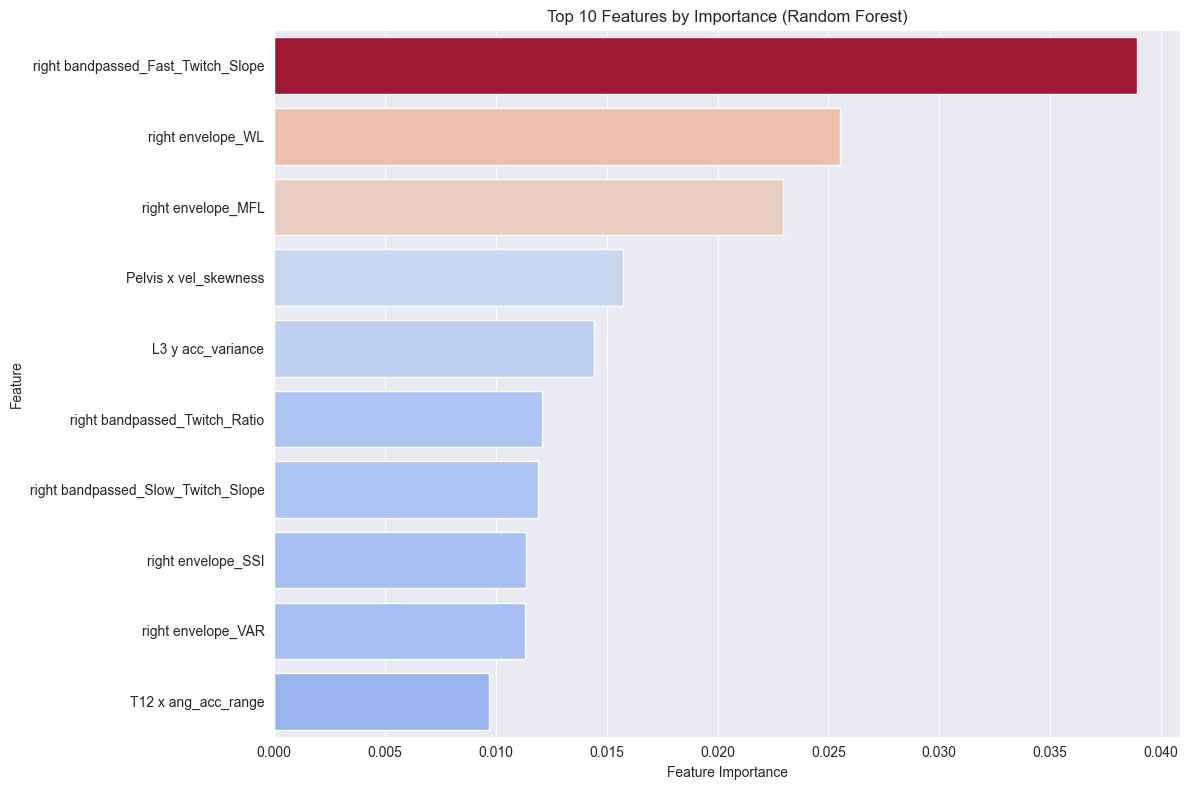

In [34]:
norm = plt.Normalize(importance_logo_df['Importance'].min(), importance_logo_df['Importance'].max())
colors = sns.color_palette("coolwarm", as_cmap=True)(norm(importance_logo_df['Importance'].head(10)))

plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=importance_logo_df.head(10),
    palette=colors
)
plt.title('Top 10 Features by Importance (Random Forest)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

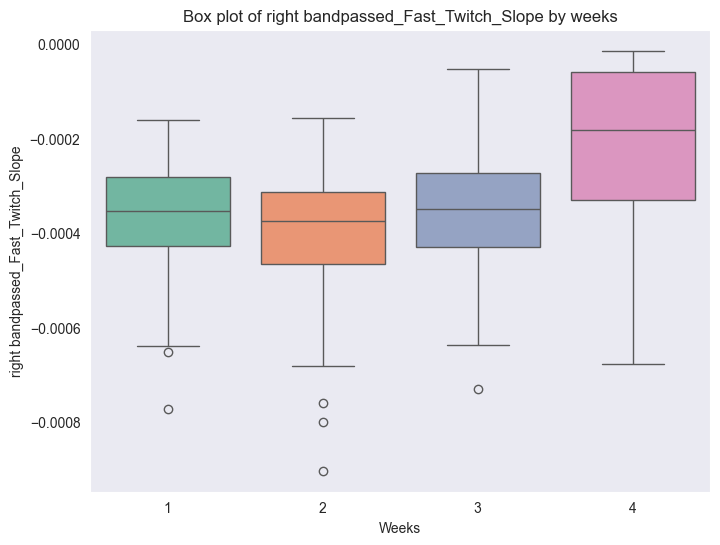

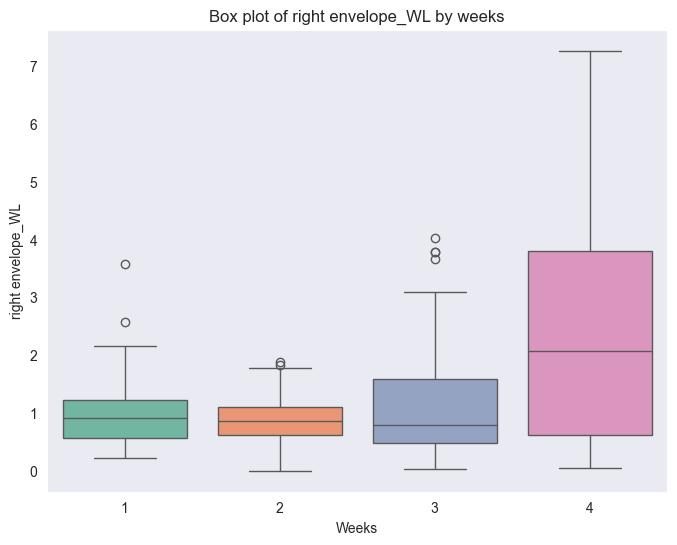

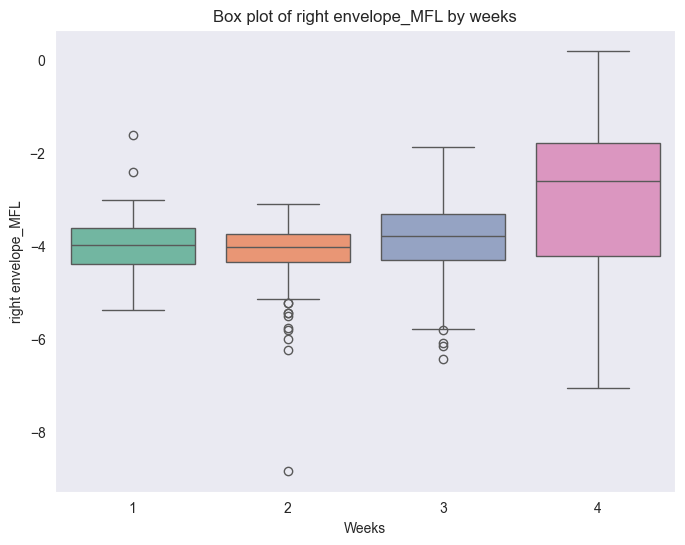

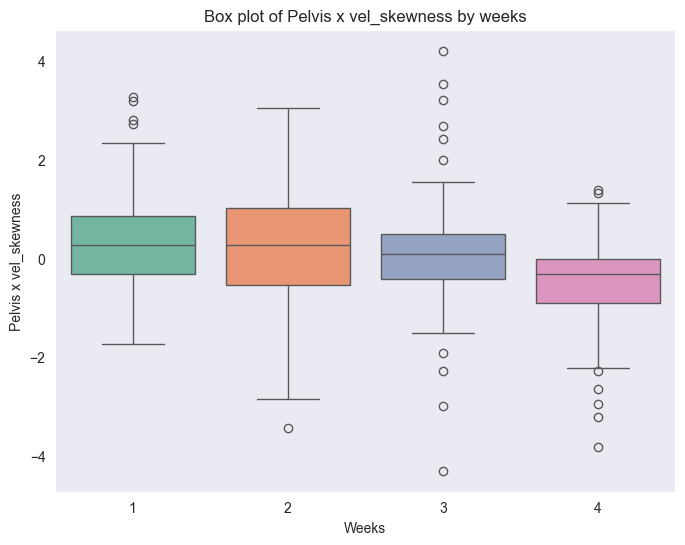

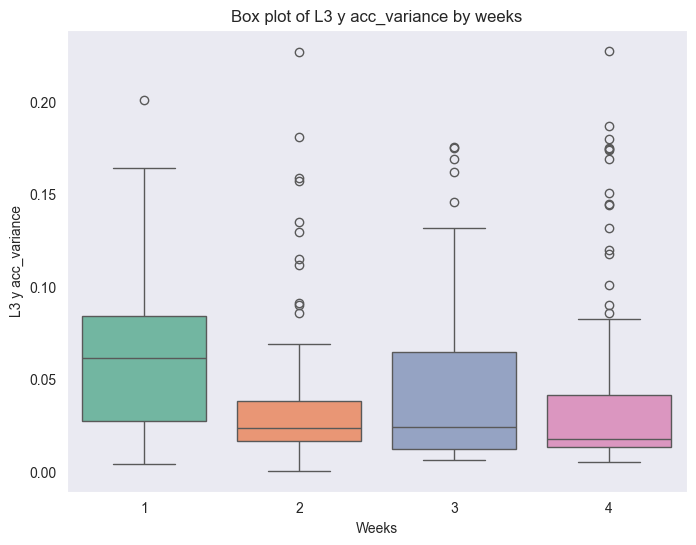

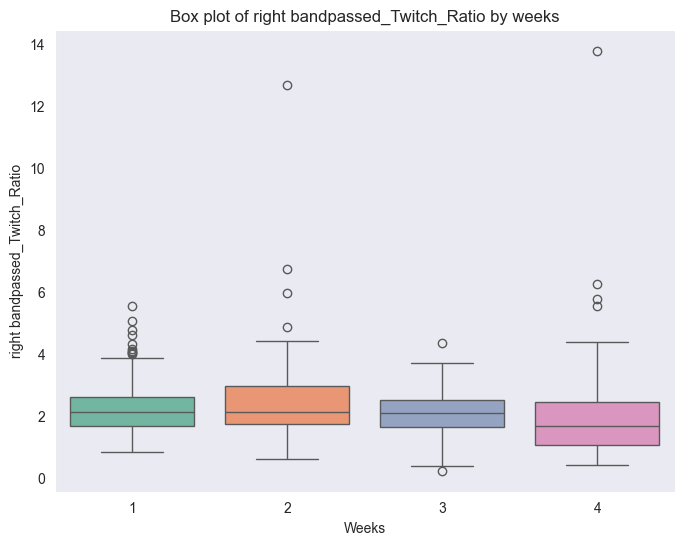

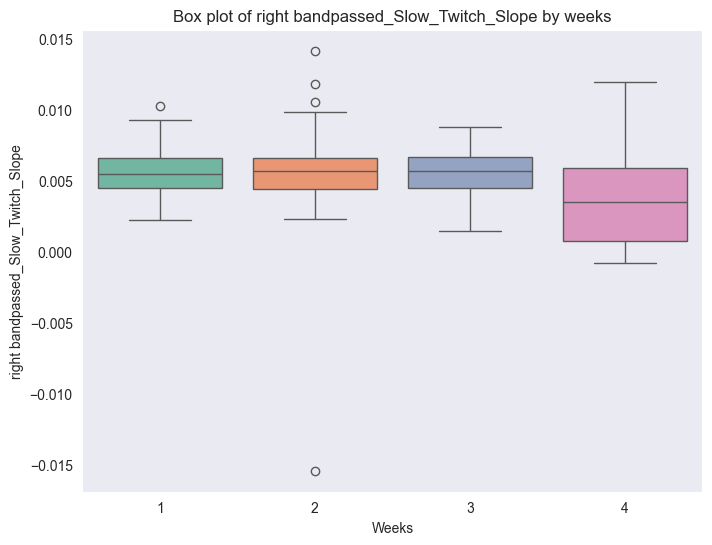

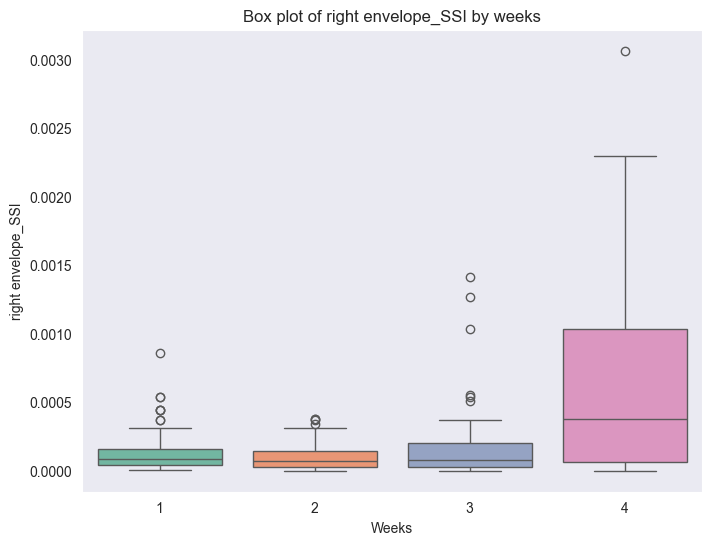

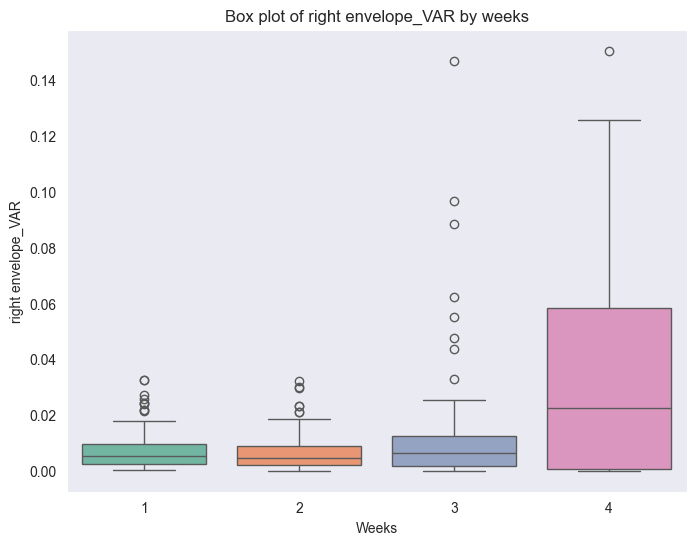

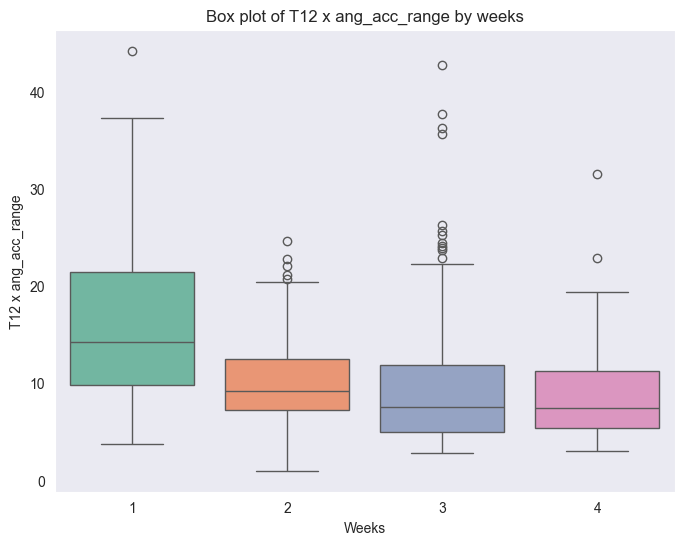

In [36]:
# Get the top 10 features
selected_features = importance_logo_df.head(10)["Feature"]

# Generate individual plots for each feature
for feature in selected_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(
        data=filtered_df,
        x='session_id',
        y=feature,
        hue='session_id',
        palette="Set2",
        dodge=False  
    )
    plt.title(f'Box plot of {feature} by weeks')
    plt.xlabel("Weeks")
    plt.ylabel(feature)
    plt.grid(axis='y') 
    plt.legend([], [], frameon=False)  
    plt.show()


## Lasso Regression

In [37]:
f = filtered_df[filtered_df["session_id"].isin([1, 4])]
X = f.drop(columns=['Participant', 'session_id', 'Rep', 'Roland-Morris', 'Oswestry Index', 'Exercise'])
y = f['session_id']
groups = f['Participant']

lr_model = LogisticRegression(penalty='l1', C=1, solver='liblinear', random_state=42)

feature_names = X.columns
all_feature_importances_5fold = []
all_feature_importances_logo = []

print("\nRunning Leave-One-Group-Out Cross-Validation...")
cv_scores_logo = []
logo = LeaveOneGroupOut()
for train_idx, test_idx in logo.split(X, y, groups):
    # Scale features within the fold
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X.iloc[train_idx])
    X_test = scaler.transform(X.iloc[test_idx])
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train and evaluate the model
    lr_model.fit(X_train, y_train)
    y_pred = lr_model.predict(X_test)
    cv_scores_logo.append(accuracy_score(y_test, y_pred))
    all_feature_importances_logo.append(np.abs(lr_model.coef_[0]))  # Absolute value of coefficients

# Average feature importance across folds
mean_importances_logo = np.mean(all_feature_importances_logo, axis=0)
print("LOGO CV Accuracy Scores:", cv_scores_logo)
print("Mean CV Accuracy (LOGO):", np.mean(cv_scores_logo))

importance_logo_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': mean_importances_logo
}).sort_values(by='Importance', ascending=False)

print(importance_logo_df["Feature"].head(20))


Running Leave-One-Group-Out Cross-Validation...
LOGO CV Accuracy Scores: [0.6666666666666666, 0.7567567567567568, 0.85, 0.5882352941176471, 0.6428571428571429, 0.5416666666666666, 0.8372093023255814, 0.6428571428571429]
Mean CV Accuracy (LOGO): 0.6907811215309505
195                               Pelvis x vel_skewness
37                   right bandpassed_Spectral_Flatness
26                    left bandpassed_Spectral_Flatness
34                   right bandpassed_Fast_Twitch_Slope
419                    Left Shoulder y ang_vel_skewness
17                                   right envelope_Max
277                                       T12 x vel_std
13                                   right envelope_VAR
129                                    T12 y acc_energy
70                                Pelvis z acc_skewness
39                    right bandpassed_Spectral_Entropy
314              Right Shoulder x vel_abs_min_fft_coeff
731                L5S1 Lateral Bending joint_angle_ROM
758    

C:\Users\Hp\AppData\Local\Temp\ipykernel_13736\2624933277.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Hp\AppData\Local\Temp\ipykernel_13736\2624933277.py:11: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


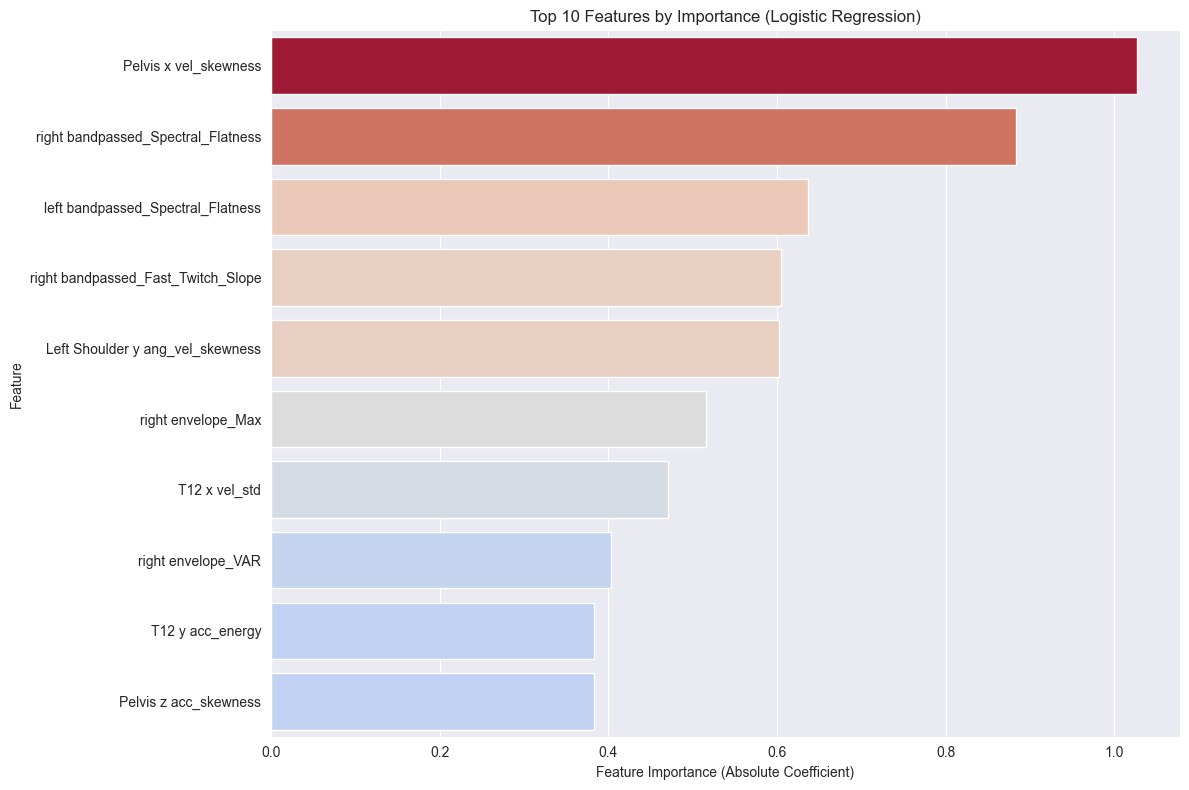

In [38]:
norm = plt.Normalize(importance_logo_df['Importance'].min(), importance_logo_df['Importance'].max())
colors = cm.coolwarm(norm(importance_logo_df['Importance'].head(10)))

plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=importance_logo_df.head(10),
    palette=colors
)
plt.title('Top 10 Features by Importance (Logistic Regression)')
plt.xlabel('Feature Importance (Absolute Coefficient)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

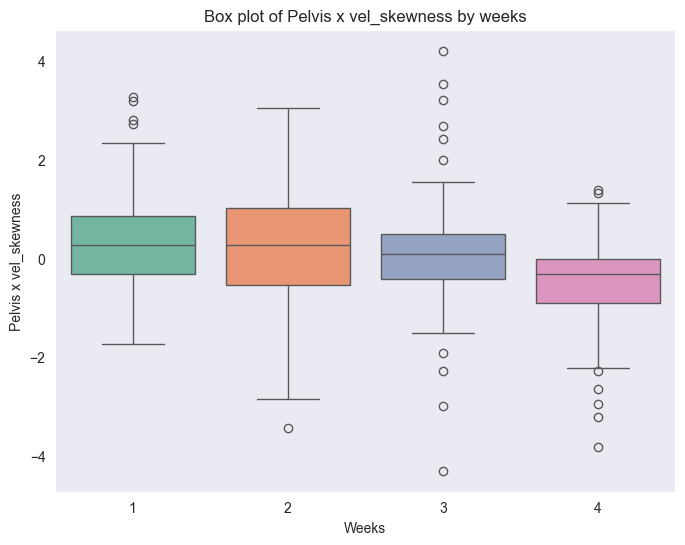

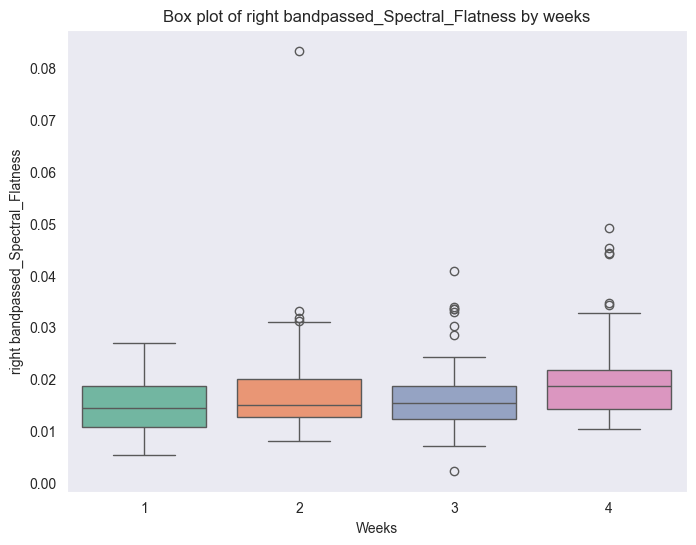

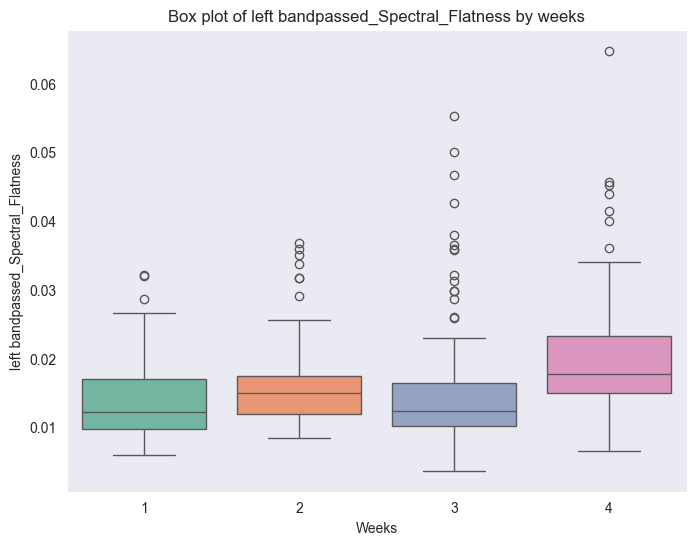

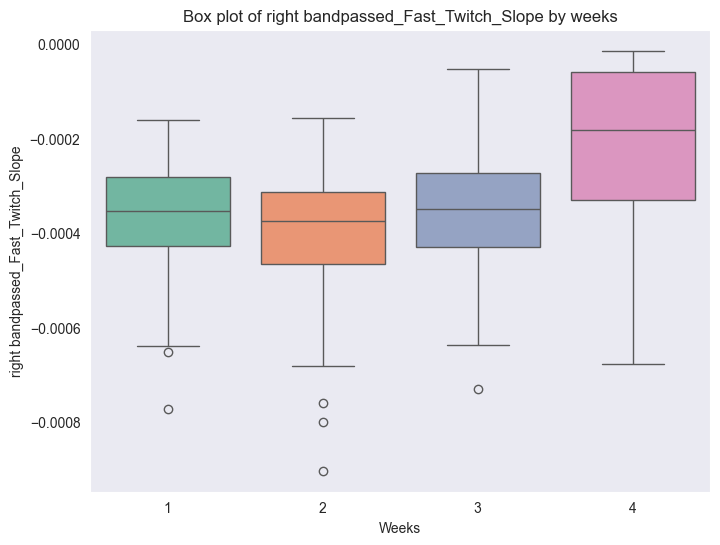

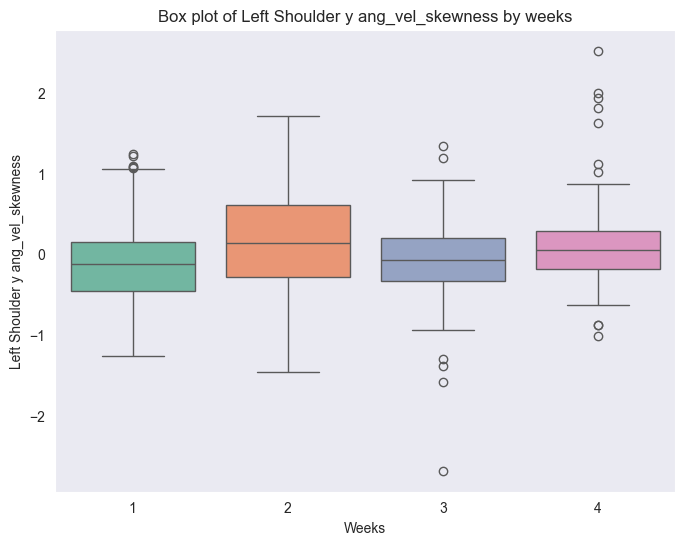

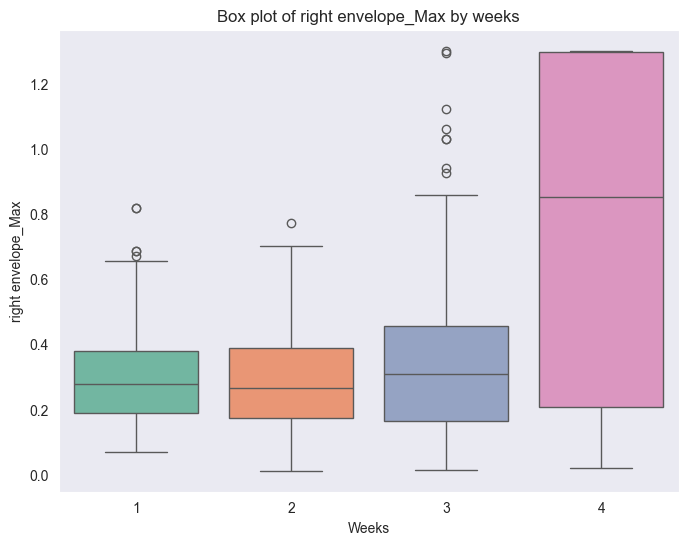

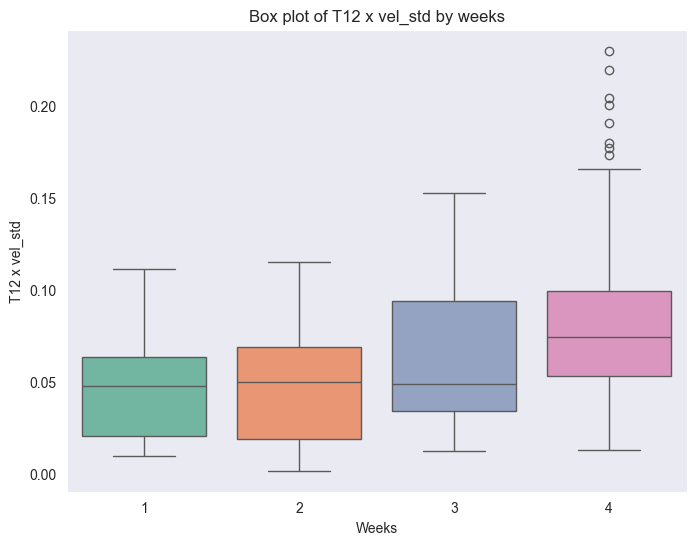

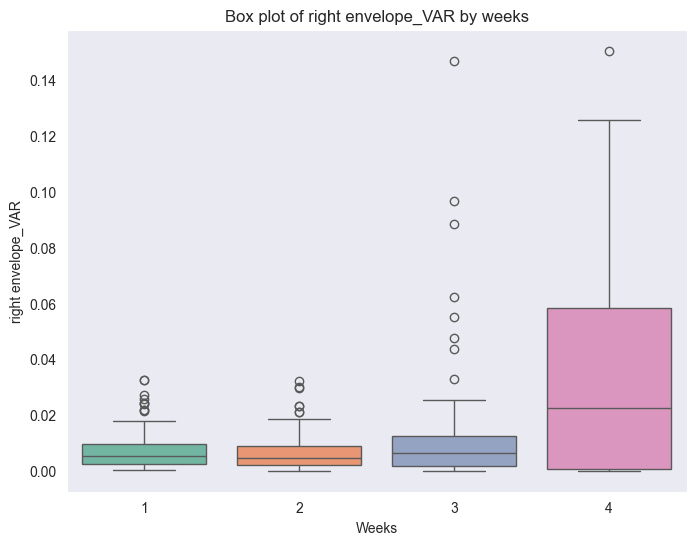

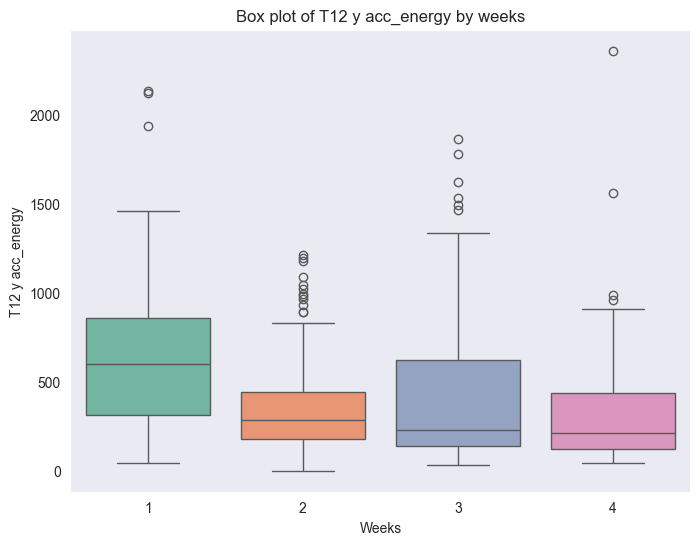

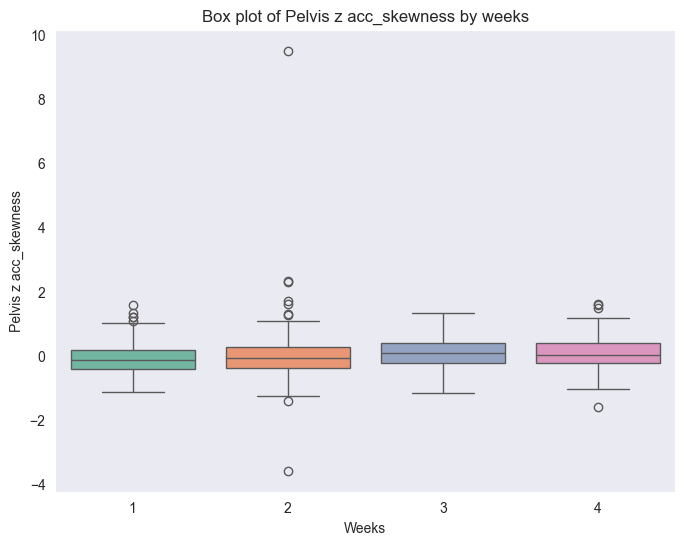

In [39]:
selected_features = importance_logo_df.head(10)["Feature"]

for feature in selected_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(
        data=filtered_df,
        x='session_id',
        y=feature,
        hue='session_id',  
        palette="Set2",
        dodge=False 
    )
    plt.title(f'Box plot of {feature} by weeks')
    plt.xlabel("Weeks")
    plt.ylabel(feature)
    plt.grid(axis='y')  
    plt.legend([], [], frameon=False)  
    plt.show()


## Anatomical landmarks

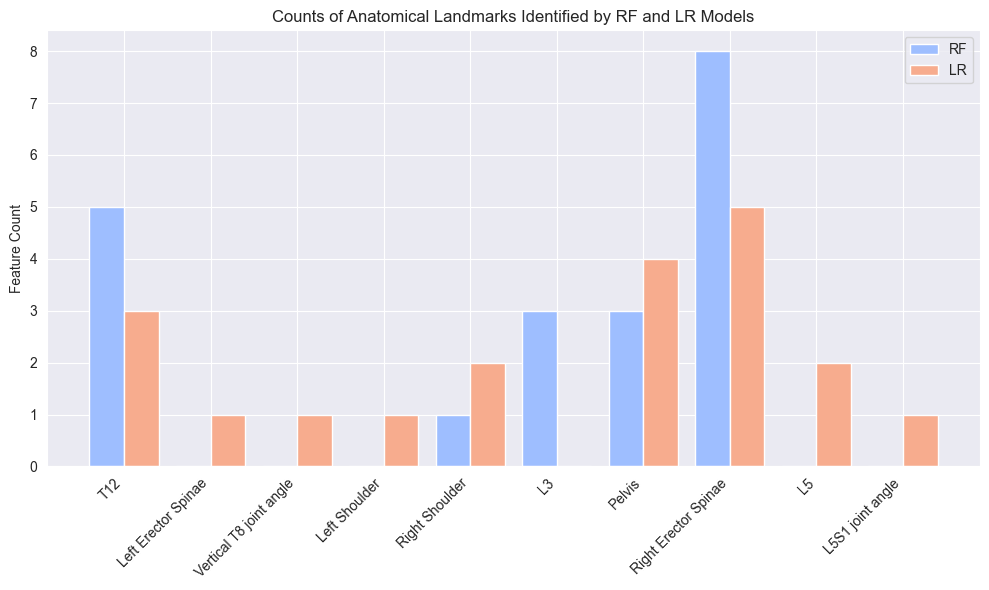

In [44]:
rf_features = [
    "right bandpassed_Fast_Twitch_Slope", "right envelope_WL", "right envelope_MFL",
    "Pelvis x vel_skewness", "L3 y acc_variance", "right bandpassed_Twitch_Ratio",
    "right bandpassed_Slow_Twitch_Slope", "right envelope_SSI", "right envelope_VAR",
    "T12 x ang_acc_range", "L3 x vel_variance", "T12 x vel_std", "T12 x vel_mean",
    "Pelvis x acc_mean", "Right Shoulder x vel_std", "L3 y ang_acc_mean",
    "right envelope_Max", "T12 x vel_abs_max_fft_coeff", "Pelvis x ang_acc_abs_max_fft_coeff",
    "T12 x acc_mean"
]

lr_features = [
    "Pelvis x vel_skewness", "right bandpassed_Spectral_Flatness", "left bandpassed_Spectral_Flatness","right bandpassed_Fast_Twitch_Slope", "Left Shoulder y ang_vel_skewness", "right envelope_Max","T12 x vel_std", "right envelope_VAR", "T12 y acc_energy", "Pelvis z acc_skewness","right bandpassed_Spectral_Entropy", "Right Shoulder x vel_abs_min_fft_coeff","L5S1 Lateral Bending joint_angle_ROM", "Vertical_T8 Lateral Bending ergo_joint_angle_ROM", "Pelvis x acc_mean", "Pelvis y vel_mean", "T12 y vel_skewness", "Right Shoulder y ang_acc_kurtosis", "L5 y ang_vel_skewness", "L5 x vel_abs_max_fft_coeff"
]

# Extract anatomical landmarks
rf_landmarks = [feature.split()[0] for feature in rf_features]
lr_landmarks = [feature.split()[0] for feature in lr_features]

# Count occurrences
rf_counts = pd.Series(rf_landmarks).value_counts()
lr_counts = pd.Series(lr_landmarks).value_counts()

# Combine into a single DataFrame
landmark_counts = pd.DataFrame({'RF': rf_counts, 'LR': lr_counts}).fillna(0)

# Update the mapping for anatomical landmarks
anatomical_mapping_updated = {
    "right": "Right Erector Spinae",
    "left": "Left Erector Spinae",
    "Left": "Left Shoulder",
    "Right": "Right Shoulder",
    "Pelvis": "Pelvis",
    "T12": "T12",
    "L3": "L3",
    "L5": "L5",
    "Vertical_T8": "Vertical T8 joint angle",
    "L5S1": "L5S1 joint angle"
}

# Apply the updated mapping to the counts for better clarity
rf_counts_updated = {anatomical_mapping_updated.get(key, key): value for key, value in rf_counts.items()}
lr_counts_updated = {anatomical_mapping_updated.get(key, key): value for key, value in lr_counts.items()}

# Ensure all keys are present in both dictionaries for consistency
all_keys_updated = set(rf_counts_updated.keys()).union(lr_counts_updated.keys())
rf_counts_final = {key: rf_counts_updated.get(key, 0) for key in all_keys_updated}
lr_counts_final = {key: lr_counts_updated.get(key, 0) for key in all_keys_updated}

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(all_keys_updated))
bar_width = 0.4


norm = Normalize(vmin=0, vmax=1)
cmap = cm.coolwarm
rf_color = cmap(norm(0.3))
lr_color = cmap(norm(0.7))  

ax.bar(
    [pos - bar_width / 2 for pos in x],
    rf_counts_final.values(),
    width=bar_width,
    label='RF',
    color=rf_color
)
ax.bar(
    [pos + bar_width / 2 for pos in x],
    lr_counts_final.values(),
    width=bar_width,
    label='LR',
    color=lr_color
)


ax.set_xticks(x)
ax.set_xticklabels(all_keys_updated, rotation=45, ha="right")
ax.set_ylabel("Feature Count")
ax.set_title("Counts of Anatomical Landmarks Identified by RF and LR Models")
ax.legend()
plt.tight_layout()
plt.show()

## Spearman

In [26]:
outcome_column = 'session_id' 

# Exclude non-feature columns
feature_columns = [col for col in filtered_df.columns if col not in ['week', 'Participant', 'session_id', 'Exercise', 'session_id_encoded', 'Rep', 'Roland-Morris', 'Oswestry Index']]
aggregated_df = filtered_df.groupby(['Participant', 'session_id'])[feature_columns].mean().reset_index()
numeric_df = aggregated_df.select_dtypes(include=['number'])
numeric_df = numeric_df.drop(columns=["Rep", "Roland-Morris", "Oswestry Index"], errors='ignore')

# Compute Spearman correlations directly for numeric_df
spearman_correlations = numeric_df.corr(method='spearman')['session_id'].drop('session_id').sort_values(ascending=False)

# Perform Spearman correlation analysis for aggregated_df
spearman_results = []
for feature in aggregated_df.columns:
    if feature not in ['Participant', 'session_id', outcome_column]:
        correlation, p_value = spearmanr(aggregated_df[feature], aggregated_df[outcome_column])
        spearman_results.append({
            'Feature': feature,
            'Spearman Correlation': correlation,
            'P-Value': p_value,
            'Fit Category': 'Moderate' if abs(correlation) > 0.4 else
                            'Low' if abs(correlation) > 0.2 else
                            'Very weak'
        })

spearman_df = pd.DataFrame(spearman_results).sort_values(by='Spearman Correlation', ascending=False)

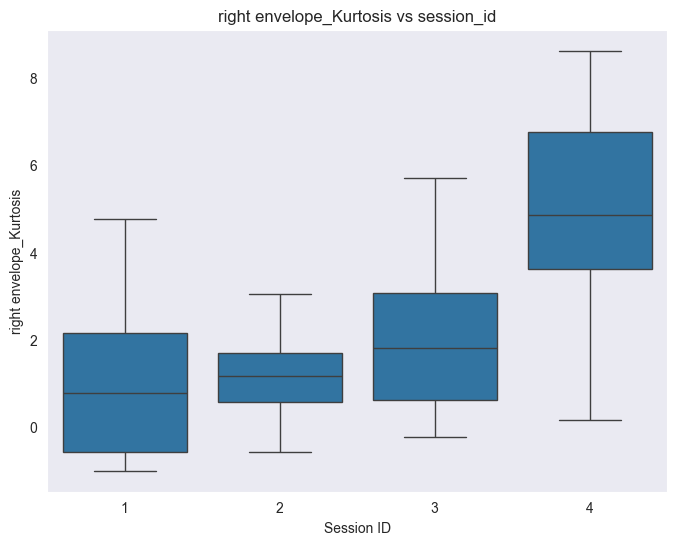

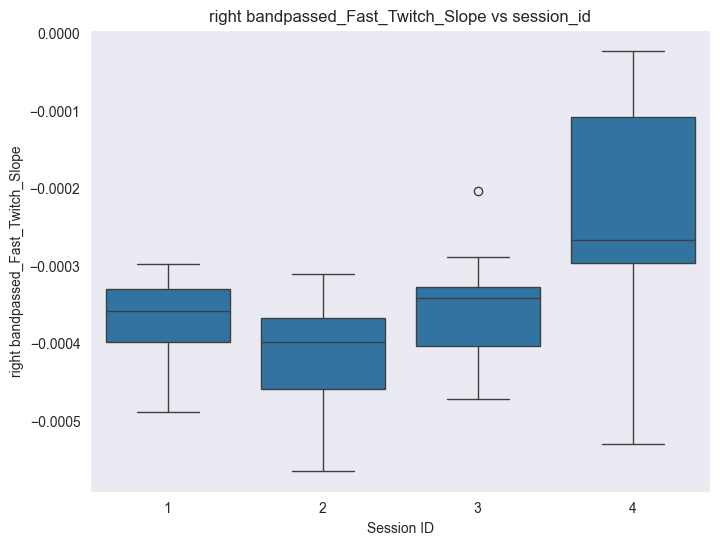

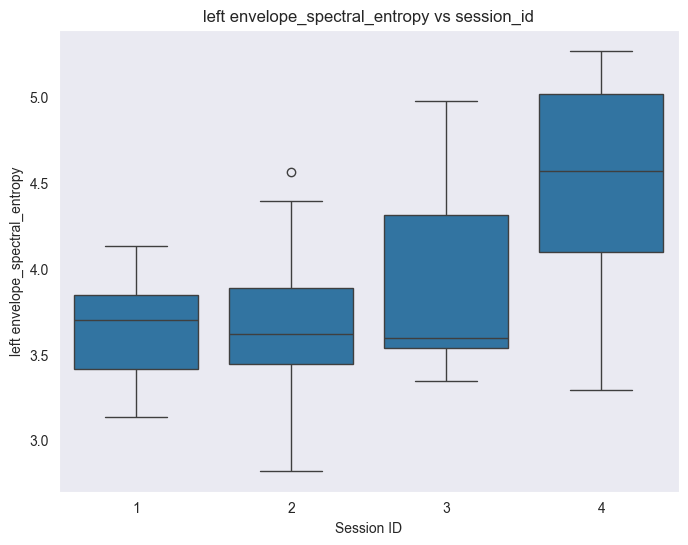

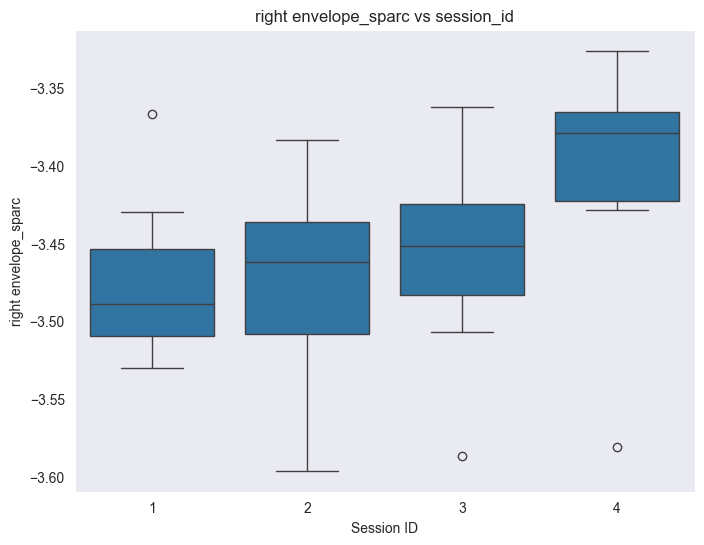

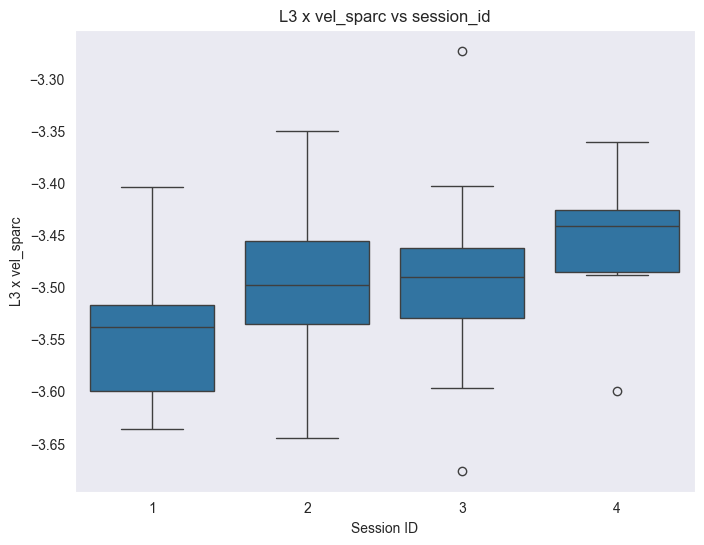

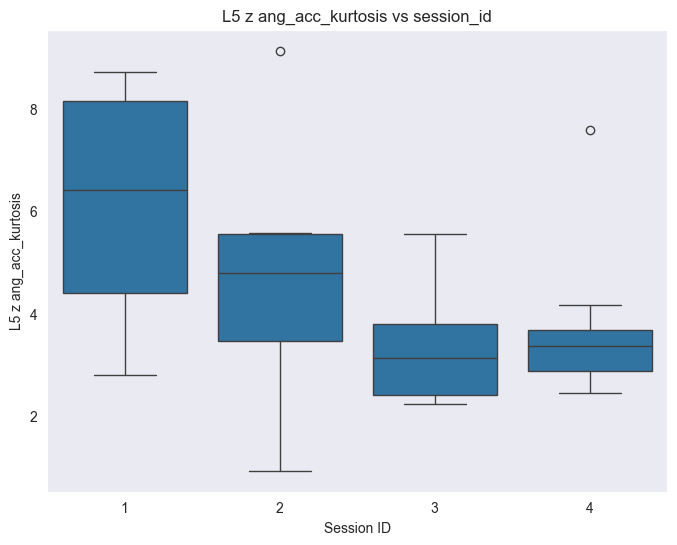

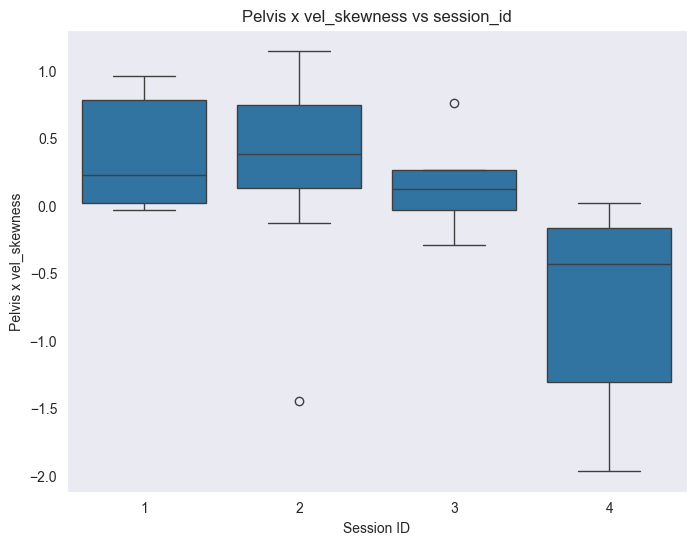

In [27]:
# Filter for features with 'Moderate' fit
moderate_features = spearman_df[spearman_df['Fit Category'] == 'Moderate']['Feature']

for feature in moderate_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=aggregated_df, x='session_id', y=feature)
    plt.title(f'{feature} vs session_id')
    plt.xlabel('Session ID')
    plt.ylabel(feature)
    plt.grid(axis='y')
    plt.show()

In [40]:
# Extract features with 'Strong' and 'Moderate' fit categories
strong_moderate_features = spearman_df[spearman_df['Fit Category'].isin(['Moderate'])]
print(strong_moderate_features["Feature"].tolist())
print(len(strong_moderate_features))

['right envelope_Kurtosis', 'right bandpassed_Fast_Twitch_Slope', 'left envelope_spectral_entropy', 'right envelope_sparc', 'L3 x vel_sparc', 'L5 z ang_acc_kurtosis', 'Pelvis x vel_skewness']
7


In [42]:
f = filtered_df[filtered_df["session_id"].isin([1, 4])]
X = f[strong_moderate_features["Feature"].tolist()]
y = f['session_id']
groups = f['Participant']
rf_model = RandomForestClassifier(random_state=42, n_estimators=50, min_samples_leaf=2, max_features='sqrt')


feature_names = X.columns
all_feature_importances_logo = []

print("\nRunning Leave-One-Group-Out Cross-Validation...")
cv_scores_logo = []
logo = LeaveOneGroupOut()
for train_idx, test_idx in logo.split(X, y, groups):
    # Scale features within the fold
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X.iloc[train_idx])
    X_test = scaler.transform(X.iloc[test_idx])
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train and evaluate the model
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    cv_scores_logo.append(accuracy_score(y_test, y_pred))
    all_feature_importances_logo.append(rf_model.feature_importances_)

# Average feature importance across folds
mean_importances_logo = np.mean(all_feature_importances_logo, axis=0)
print("Mean CV Accuracy (LOGO):", np.mean(cv_scores_logo))

importance_logo_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': mean_importances_logo
}).sort_values(by='Importance', ascending=False)

print(importance_logo_df["Feature"].head(7))


Running Leave-One-Group-Out Cross-Validation...
Mean CV Accuracy (LOGO): 0.7537038699829397
1    right bandpassed_Fast_Twitch_Slope
6                 Pelvis x vel_skewness
3                  right envelope_sparc
2        left envelope_spectral_entropy
5                 L5 z ang_acc_kurtosis
0               right envelope_Kurtosis
4                        L3 x vel_sparc
Name: Feature, dtype: object
